In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split

Matplotlib is building the font cache; this may take a moment.


In [2]:
X, y = make_classification(
    n_samples=1000,
    n_features=10,
    n_informative=5,
    n_redundant=2,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print("Dataset ready.")


Dataset ready.


In [3]:
from sklearn.linear_model import LogisticRegression

log_model = LogisticRegression(max_iter=5000)
log_model.fit(X_train, y_train)

y_proba_log = log_model.predict_proba(X_test)[:, 1]

print("Logistic Regression trained.")


Logistic Regression trained.


In [4]:
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

print("Random Forest trained.")


Random Forest trained.


In [5]:
import evaluation

_, _, _, auc_log = evaluation.compute_roc_auc(y_test, y_proba_log)
_, _, _, auc_rf = evaluation.compute_roc_auc(y_test, y_proba_rf)

print("Logistic AUC:", auc_log)
print("Random Forest AUC:", auc_rf)


Logistic AUC: 0.9119318181818181
Random Forest AUC: 0.9897017045454546


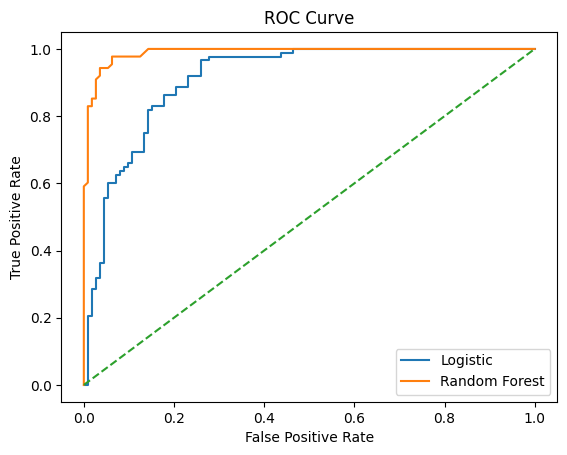

In [6]:
fpr_log, tpr_log, _, _ = evaluation.compute_roc_auc(y_test, y_proba_log)
fpr_rf, tpr_rf, _, _ = evaluation.compute_roc_auc(y_test, y_proba_rf)

plt.plot(fpr_log, tpr_log, label="Logistic")
plt.plot(fpr_rf, tpr_rf, label="Random Forest")
plt.plot([0,1], [0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()
